<h1> Ensemble generation submission and analysis notebook </h1>

This script uses a combination of bash and python cells to form a workflow for creating and analysing FATES (or any CLM) ensembles. It will:

<ol>
<li>Clone the github repo 
<li>Make and build a default 4x5 CLM-FATES case
<li>Make an ensemble of CLM-FATES cases 
<li>Generate an ensemble of parameter files with one at a time or latin hypercube  modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

n.b. This notebook is also set up to work with Cheyenne specific paths, but can be modified. 

The version here is relatively simple in that it just submits a one at a time sensemble and plots maps of the output. Obviously much more can be made of the ensemble design and analysis but this is here as a generic tool... 

#### INITIALISE: Control variables for the analysis script.

In [1]:
# This mega script does 
# ensemble setup (including parameter file generation.  
# job submission and 
# analysis. 

# You can turn these off and on according to where you are tin the process. 

dosetup = 0 #do we want to create parameters files and so on?
dosubmit = 0 #do we do the submission stage, or just the analysis?
forcenewcase = 0 #do we scurb all the old cases and start again?
doanalysis = 1 #do we want to plot the outputs? 
print("setup, submit, analysis:", dosetup,dosubmit,doanalysis)

setup, submit, analysis: 0 0 1


#### INITIALISE: Define parameter space for senstivity analysis. 

In [2]:
#aspiration to make this into a dictionary...
n=1 #the number of the ensemble. For when you need to do it all again ;) 

if(n == 1):
    parameter_list=['fates_rad_leaf_clumping_index','fates_rad_leaf_xl',
                'fates_rad_leaf_rhovis','fates_rad_stem_rhovis',
                'fates_rad_leaf_tauvis','fates_rad_stem_tauvis' ,
               'fates_vai_top_bin_width','fates_vai_width_increase_factor']
    parameter_label=['clumping_index','leaf_xl',
                'leaf_rhovis','stem_rhovis',
                'leaf_tauvis','stem_tauvis' ,
               'top_bin_width','width_increase_factor']
    nparams = 8
    pmode = 1 #mode of varying the parameters. OAAT. 
    #how many members are in the ensemble?
    sp=1 #are we using SP mode?
    ncases=nparams*2
    min_delta=[0.5,   0.01,0.75, 0.75, 0.75,0.75, 0.25, 1.1]
    max_delta=[1/0.85,1.4 ,1.25, 1.25, 1.25,1.25, 0.5, 1.25]
    
# ensemble 2 is to look at a range of absolute values of xl
if(n == 2):
    pvalue=[-0.99, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 0.99]
    ncases = 8 #(this is zero indexed)
    parameter_list=['fates_rad_leaf_xl']
    pmode = 2 #just vary this one parameter. 
    parameter_label=['leaf_xl']
    sp=1 #are we using SP mode?
    
print(parameter_list)  

['fates_rad_leaf_clumping_index', 'fates_rad_leaf_xl', 'fates_rad_leaf_rhovis', 'fates_rad_stem_rhovis', 'fates_rad_leaf_tauvis', 'fates_rad_stem_tauvis', 'fates_vai_top_bin_width', 'fates_vai_width_increase_factor']


#### INITIALISE: Import libraries

In [3]:
import os
import netCDF4 as nc4
import sys
import shutil
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
#import datetime

#### INITIALISE: Set pathnames for parameter directories and casenames.

In [4]:
# what is your clone of the ctsm repo called? (or you want it to be called?) 
ctsmrepo='ctsmsep22'

#what do you want the directory with the ensemble cases in to be called?
ens_directory='RTM_ens'+str(n)

#what do you want the case names to begin with?
caseroot=ens_directory+'_case_'

USER='rfisher'

#path to scratch (or where the model is built.)
defbuildroot='/glade/scratch/'

#path to scratch (or where the model is built.)
output_dir='/glade/scratch/'+USER+'/'

#where are we now?
notebookdr=os.getcwd() 

# git directory. aka where do you want the code and scripts to live?
gitpath = '/glade/work/'+USER+'/'

# some more derived path names to simplify latter scripts
scriptsdir=gitpath+'/git/'+ctsmrepo+'/cime/scripts/'


#### INITIALISE: SP/NOCOMP specific paths to default case/param files

In [5]:
if(sp == 1): #Settings for the SP ensemble.
    resub=0 #how many times to resubmit the model. 

    #what is the name of your 'basecase'?
    defcase='fates_crops_smo_minlai_opt_vcmax50'
    
    #what is the base parameter file called?
    paramfiledefault='fates_params_default.nc'    

else: #Settings for the NOCOMP ensemble. 
    resub=2 #how many times do we want to resubmit the job?
    
    #what is the name of your 'basecase'?
    defcase='SPdefault_sept'
    
    #what is the base parameter file called?
    paramfiledefault='fates_params_default.nc'   
    
#set up the parameter file paths even if not in 'setup' mode
paramsdir = scriptsdir+'/'+ens_directory+'/parameter_files'
defparamdir = gitpath+'/git/'+ctsmrepo+'/src/fates/parameter_files/'


#### INITIALISE: Make a function that creates directories if they don't already exist

In [6]:
def make_directory(fileroot):   
    if(os.path.isdir(fileroot)):
        print('dir exists:'+fileroot)
    else:
        os.mkdir(fileroot)
        print('made: '+fileroot)

#### SETUP: Make a git repo if needed. 

In [7]:
make_directory(gitpath+'git')

dir exists:/glade/work/rfisher/git


#### SETUP: Clone CTSM repo (if necessary). BASH

In [8]:
%%bash -s "$ctsmrepo" "$dosetup"
ctsmrepo=$1
dosetup=$2

if [ $dosetup -eq 1 ]
then
cd /glade/work/$USER/git
#go to git directory
pwd
#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
echo "Already have ctsm repo"
else
echo "Cloning ctsm"
#clone CTSM code if you didn't to this already. 
git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
./manage_externals/checkout_externals
cd src
fi
fi


#### SETUP: Make a default FATES 4x5 case BASH 

In [9]:
%%bash -s "$scriptsdir" "$dosetup" "$defcase" 
scriptsdir=$1
dosetup=$2
defcase=$3
echo "defcase is" $defcase
echo "setup=" $dosetup
echo $dosetup
compset=2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP
if [[ $dosetup -eq 1 ]]
then
cd $scriptsdir
if [[ -d "$defcase" ]]
then
    echo "$defcase exists on your filesystem." .$defcase
else
    echo "making defcase.",$defcase
./create_newcase --case $defcase --compset 2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP --res f45_f45_mg37  --run-unsupported
cd $defcase
./case.setup
./case.build
fi
fi
echo "Currently in" $(pwd)

defcase is fates_crops_smo_minlai_opt_vcmax50
setup= 0
0
Currently in /glade/u/home/rfisher/fates_sp_ensembles


#### SETUP: Adjust settings of default case. BASH 

In [10]:
%%bash -s "$scriptsdir" "$defcase" "$dosetup" 

scriptsdir=$1
defcase=$2
dosetup=$3

if [[ $dosetup -eq 1 ]]
then
defbld=$defbuildroot$USER/$defcase/bld
cd $scriptsdir$defcase

echo 'updating settings'
./xmlchange CONTINUE_RUN=FALSE;  
./xmlchange --id STOP_N --val 5;  #number of years of simulation
./xmlchange --id STOP_OPTION --val nyears;
./xmlchange --id CLM_FORCE_COLDSTART --val on;
echo "Currently in" $(pwd)
fi

#### SETUP: Make ensemble and parameter directory

In [11]:
make_directory(scriptsdir+ens_directory)
make_directory(scriptsdir+ens_directory+'/parameter_files' )

dir exists:/glade/work/rfisher//git/ctsmsep22/cime/scripts/RTM_ens1
dir exists:/glade/work/rfisher//git/ctsmsep22/cime/scripts/RTM_ens1/parameter_files


#### SETUP: Make ensemble of CLM cases BASH

In [12]:

%%bash -s "$scriptsdir" "$defcase" "$dosetup" "$ens_directory" "$caseroot" "$ncases" "$forcenewcase"

scriptsdir=$1
defcase=$2
dosetup=$3
ens_directory=$4
caseroot=$5
ncases=$6
forcenewcase=$7

echo "ncases=" $ncases
echo "caseroot=" $caseroot
echo "dosetup=" $dosetup
echo "forcenewcase=" $forcenewcase
echo "ens_directory=" $ens_directory

if [[ $dosetup -eq 1 ]]
then
cd $scriptsdir

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1 #name of ensemble membr case.    
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase
    if [ $forcenewcase -eq 1 ]
    then
    echo 'force making case', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    echo 'case setup', $ens_directory/$newcase
    ./case.setup;
     cd ../../ 
    fi    
  else
   echo 'making new case', $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    echo 'case setup', $ens_directory/$newcase
    ./case.setup;
    cd ../../ 
  fi
((counter1++))
done

fi

ncases= 16
caseroot= RTM_ens1_case_
dosetup= 0
forcenewcase= 0
ens_directory= RTM_ens1


#### SETUP: Create/ncgen a .nc version of current default (.cdl) file. 

In [13]:
if(dosetup == 1): 
    newfilenc=defparamdir+'fates_params_default.nc'
    template_cdl=defparamdir+'fates_params_default.cdl'

    if(os.path.isfile(newfilenc)):
       os.remove(newfilenc)    
    os.system('ncgen '+template_cdl+' -o '+newfilenc)
    os.listdir(defparamdir)

#### SETUP: Copy default template parameter file to ensemble parameter directory

In [14]:
if(dosetup == 1): 
    filename_template = paramsdir+'/'+paramfiledefault
    print(filename_template)
    if(os.path.isfile(filename_template)):
       os.remove(filename_template)    
    shutil.copy(newfilenc,filename_template)

#### SETUP: Make a default user_nl_clm file

In [15]:
if (dosetup == 1 ):
    defcasedir = scriptsdir+'/'+defcase #where is the vanilla file?
    os.chdir(defcasedir) #go to the def case dir

    if(os.path.isfile('user_nl_clm_default')):
        #squash the existing default file
        os.remove('user_nl_clm_default')
    else:    
        #move the vanilla version to the default version
        shutil.copy(user_nl_clm, user_nl_clm_default)

#### SETUP: Write configuration and dummy parameter filename into defualt user_nl_clm file

In [16]:
if (dosetup == 1 ):   
    f = open('user_nl_clm_default', 'a')
    if (sp ==1): #change to SP mode. 
        f.write('use_fates_sp = true')
        f.write('\n')
    f.write('fates_paramfile = "nullparameterfile"')
    f.close()
    # copy this 'fresh' default file into the ensemble directory. 
    shutil.copy('user_nl_clm_default', scriptsdir+'/'+ens_directory+'/user_nl_clm_default')
    
    #check what you made!
    os.system("cat user_nl_clm_default")
    os.chdir(notebookdr)
print('end')

end


#### SETUP: Create ensemble of parameter files

In [17]:
if(dosetup == 1): 
    fatesparamfile= 'fates_params_'+ens_directory+'_'
    vs=range(0,ncases+1) 
    for i in vs:
        filename_out = paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
        #print('make:'+filename_out)
        try:
            os.remove(filename_out)
        except:
            print('file does not yet exist: '+filename_out)
        shutil.copy(filename_template,filename_out)
print('end')

end


#### SETUP: Make function to modify FATES parameter files. 

In [18]:
def def_pftfile( fileroot,i,variable,pmode,delta):   
    pfilename = fileroot+str(i)+'.nc' 
    fin = nc4.Dataset(pfilename, 'r+')
    print('modifying parameter file',i,variable,delta);
    var = fin.variables[variable]
    if(pmode == 1): #multiplicative peturbation
        var[:] = var[:]*delta
    if(pmode == 2): 
        var[:] = var[:]*0+delta
    fin.close()

#### SETUP: Modify parameter files (one at a time)

In [19]:
if(dosetup == 1): 
    fileroot =  paramsdir+'/'+fatesparamfile 
    if(pmode == 1): #OAAT
        for p in range(0,8):
            def_pftfile(fileroot,p*2+1,parameter_list[p],pmode,min_delta[p])
            def_pftfile(fileroot,p*2+2,parameter_list[p],pmode,max_delta[p])

    if(pmode == 2): #single p variation. 
        for i in vs:
            def_pftfile(fileroot,i,parameter_list[0],pmode,pvalue[i])


#### SETUP: Point each ensemble script at different parameter file

In [20]:
if(dosetup == 1): 
    root= scriptsdir+'/'+ens_directory+'/'
    vs=range(0,ncases+1) 
    print('paramsdir=',paramsdir)
    for i in vs:
        pftfilename = paramsdir+'/'+fatesparamfile+str(i)+'.nc'    
        unlfile=root+caseroot+str(i)+'/'+'user_nl_clm'
        defunl=scriptsdir+'/'+ens_directory+'/user_nl_clm_default' 
        print('defult unl='+defunl)
        print('case unl='+unlfile)
        shutil.copy(defunl,unlfile)
        print('unl='+unlfile)   
        fin = open(unlfile, "rt")     
        data = fin.read()   #read file contents to string   
        data = data.replace('nullparameterfile',pftfilename) #replace all occurrences of the required string        
        fin.close() #close the input file       
        fin = open(unlfile, "wt") #open the input file in write mode     
        fin.write(data) #overrite the input file with the resulting data       
        fin.close() #close the file
!cat '/glade/work/rfisher/git/ctsmsep22/cime/scripts//RTM_ens1/RTM_ens1_case_7/user_nl_clm'

r14i4n28
use_fates_sp = true
fates_paramfile = "/glade/work/rfisher//git/ctsmsep22/cime/scripts//RTM_ens1/parameter_files/fates_params_RTM_ens1_7.nc"

#### SETUP: Check parameter files were correctly modifed

In [22]:
if(dosetup == 1):
    i=3
    paramnum=0
    pf= paramsdir+'/'+fatesparamfile+str(0)+'.nc' 
    print(pf)
    find = nc4.Dataset(pf, 'r+')
    vardef=find.variables[parameter_list[paramnum]]
    pf= paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
    print(pf)
    finm = nc4.Dataset(pf, 'r+')
    varmod=finm.variables[parameter_list[paramnum]]
    if(pmode == 1):
        print('actual ratio:',np.divide(varmod[:],vardef[:]))
        print('target ratio:',min_delta[paramnum])
    if(pmode == 2):
        print('actual value:',varmod[:])
        print(pvalue[i])       

#### SUBMISSION: Submit ensemble of cases BASH

In [ ]:
%% capture
%%bash -s "$scriptsdir" "$defcase" "$ens_directory" "$caseroot" "$ncases" "$dosubmit" 

scriptsdir=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6
echo $dosubmit
if [ $dosubmit -eq 1 ]
then
cd $scriptsdir

echo 'submitting'
startcase=0
counter1=$startcase
cd $ens_directory

while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    cat user_nl_clm
    echo 'submitting job',$newcase
    ./xmlchange BUILD_COMPLETE=TRUE
    #./xmlchange RESUBMIT=1
   # ./xmlchange PROJECT=P93300041
    ./case.submit
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

#### check progress of jobs


In [ ]:
rund=output_dir+caseroot+str(7)+'/run'
print(rund)
os.system('ls -lrt '+rund)

<h2>Analyse output</h2>

### Paths for analysis

In [23]:
if doanalysis ==1: 
    output='/glade/scratch/rfisher/'
    conv = 3600*24*365
    yr='.clm2.h0.'   
    ychoose=2001
    delta=1
    print('ychoose=', ychoose)
    rel=1

ychoose= 2001


#### ANALYSIS: Choose variables to read in

In [24]:
vars=['FATES_GPP','FSR','SABV','SABG','lat','lon','time']

 #### ANALYSIS: Make output figure directory

In [25]:
figpath = (notebookdr+'/'+ 'figs_'+ens_directory+'/')
make_directory(figpath)

dir exists:/glade/u/home/rfisher/fates_sp_ensembles/figs_RTM_ens1/


####  ANALYSIS: Make a single data structure for the ensemble

In [26]:
ychoose=2000
print(output_dir)
if doanalysis ==1:
    debug=1
    hstring='.clm2.h0.'
    vs=range(0,ncases+1)
    count=1
    print(caseroot)
    print(vs)

    for i in vs:       
        run=caseroot+str(i)
        os.listdir(output_dir + '/archive')
        arc = output_dir + 'archive/' + run + '/lnd/hist/' 
        hpath = arc
        tfile = run+hstring+str(ychoose)+'-06.nc'
        if(os.path.isdir(hpath)): 
            #print('is archive')
            if(os.path.isfile(hpath+tfile)): 
                if debug == 1 :print('file in archive')
            else:
                if debug == 1 :print('file not in archive',hpath+tfile)
        else:
            if(debug == 1):print('no archive')
            hpath = output_dir + run + '/run/'            
            if(os.path.isdir(hpath)): 
                print('is rundir',hpath)                
                if(os.path.isfile(hpath+tfile)):
                    if debug == 1 :print('file in  rundir')
                else:
                    print('no file in  rundir',hpath+tfile)
            else:
                print('no  rundir',hpath)
 
        allvars=list(xr.open_dataset(hpath+tfile, decode_times=False).variables)
        dropvars=list(set(allvars) - set(vars)) #thanks to Ben for figuring this part out :) 
        print('file'+str(i)+' ='+hpath+tfile)
        tmp=xr.open_mfdataset(hpath+tfile, decode_times=False, drop_variables=dropvars)

        if i==0:
            dsc = tmp           
        else:
            dsc=xr.concat([dsc,tmp],'ens')

print('end')

/glade/scratch/rfisher/
RTM_ens1_case_
range(0, 17)
file in archive
file0 =/glade/scratch/rfisher/archive/RTM_ens1_case_0/lnd/hist/RTM_ens1_case_0.clm2.h0.2000-01.nc
file in archive
file1 =/glade/scratch/rfisher/archive/RTM_ens1_case_1/lnd/hist/RTM_ens1_case_1.clm2.h0.2000-01.nc
file in archive
file2 =/glade/scratch/rfisher/archive/RTM_ens1_case_2/lnd/hist/RTM_ens1_case_2.clm2.h0.2000-01.nc
file in archive
file3 =/glade/scratch/rfisher/archive/RTM_ens1_case_3/lnd/hist/RTM_ens1_case_3.clm2.h0.2000-01.nc
file in archive
file4 =/glade/scratch/rfisher/archive/RTM_ens1_case_4/lnd/hist/RTM_ens1_case_4.clm2.h0.2000-01.nc
file in archive
file5 =/glade/scratch/rfisher/archive/RTM_ens1_case_5/lnd/hist/RTM_ens1_case_5.clm2.h0.2000-01.nc
file in archive
file6 =/glade/scratch/rfisher/archive/RTM_ens1_case_6/lnd/hist/RTM_ens1_case_6.clm2.h0.2000-01.nc
file in archive
file7 =/glade/scratch/rfisher/archive/RTM_ens1_case_7/lnd/hist/RTM_ens1_case_7.clm2.h0.2000-01.nc
file in archive
file8 =/glade/scratc

In [ ]:
#print(allvars)

####  ANALYSIS: Save data in netcdf file just incase

In [27]:
outfile=figpath+'/dataout.nc' 
dsc.to_netcdf(outfile)
os.listdir(figpath)

['dataout.nc']

####  ANALYSIS:  Make a function to plot relative differences between runs

In [28]:
def make_diff_figure(dsc,v,rel,conv,ncases,pmode,parameter_list):   
    fig = plt.figure()
    if(pmode == 1):
        plt.rcParams['figure.figsize'] = [27,7]
    if(pmode == 2):
        plt.rcParams['figure.figsize'] = [17,7]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    vs=range(1,ncases+1)
    nrow=2
    ncol=(ncases+1) // 2
    count=1
    var_0=dsc[vars[v]].isel(ens=0)
    defm=np.multiply(np.mean(var_0,0),conv)
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        p=((count+1) // 2)-1
        ax = fig.add_subplot(nrow, ncol, index)
        var_i=dsc[vars[v]].isel(ens=i)
        mod=np.multiply(np.mean(var_i,0),conv)
        
        delt=mod-defm
        plt1=delt.plot(cmap='RdYlBu')
                  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if(pmode == 1):
            if((count+1) % 2==0):
                ex=' x'+str(min_delta[p])
            else:
                ex=' x'+str(max_delta[p])
            ax.set_title(str(parameter_label[(((count+1) // 2))-1]+ex))

        if(pmode == 2):
            ex = ' x'+str(pvalue[i])
            ax.set_title(str(parameter_label[0]+ex))
            #plt1.set_clim(-3,3)

        count=count+1
        fig.canvas.draw()
       # time.sleep(1) 
        figname = figpath+ens_directory+vars[v]+'.png'
    print(figname)
    plt.savefig(figname)
          

/glade/u/home/rfisher/fates_sp_ensembles/figs_RTM_ens1/RTM_ens1FATES_GPP.png


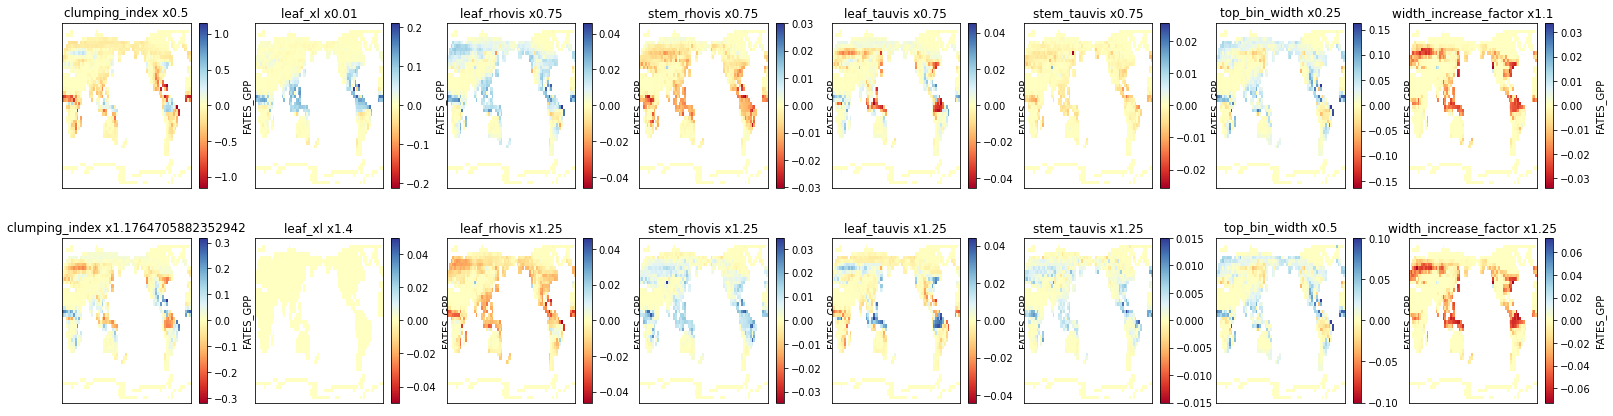

In [30]:
make_diff_figure(dsc,0,rel,3600*365*24,ncases,pmode,parameter_list)

/glade/u/home/rfisher/fates_sp_ensembles/figs_RTM_ens1/RTM_ens1FSR.png


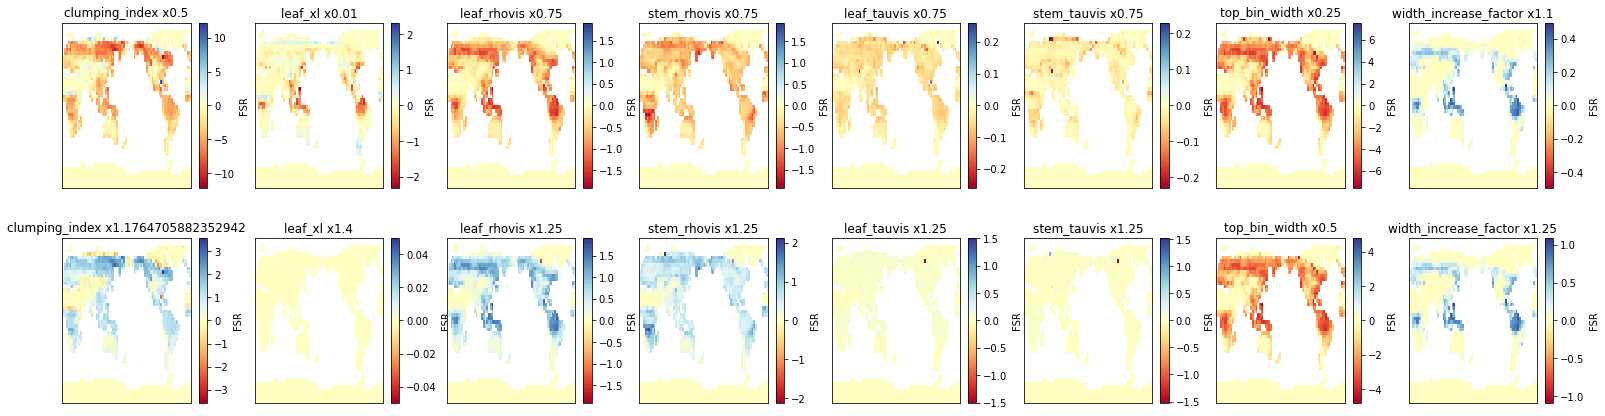

In [31]:
conv=1
make_diff_figure(dsc,1,rel,conv,ncases,pmode,parameter_list)

/glade/u/home/rfisher/fates_sp_ensembles/figs_RTM_ens1/RTM_ens1SABV.png


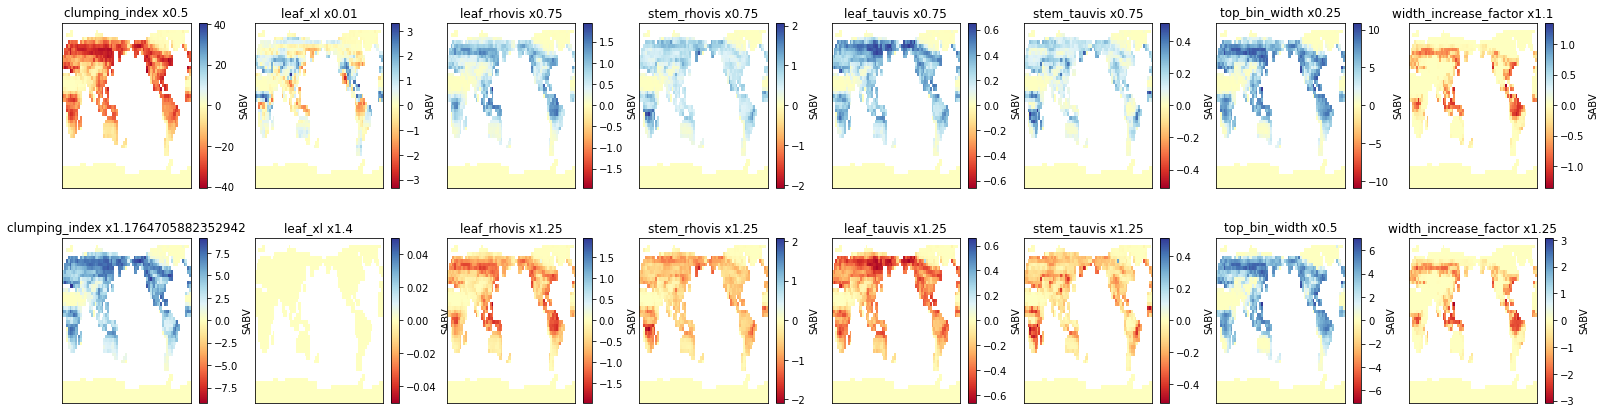

In [33]:
conv=1
make_diff_figure(dsc,2,rel,conv,ncases,pmode,parameter_list)

/glade/u/home/rfisher/fates_sp_ensembles/figs_RTM_ens1/RTM_ens1SABG.png


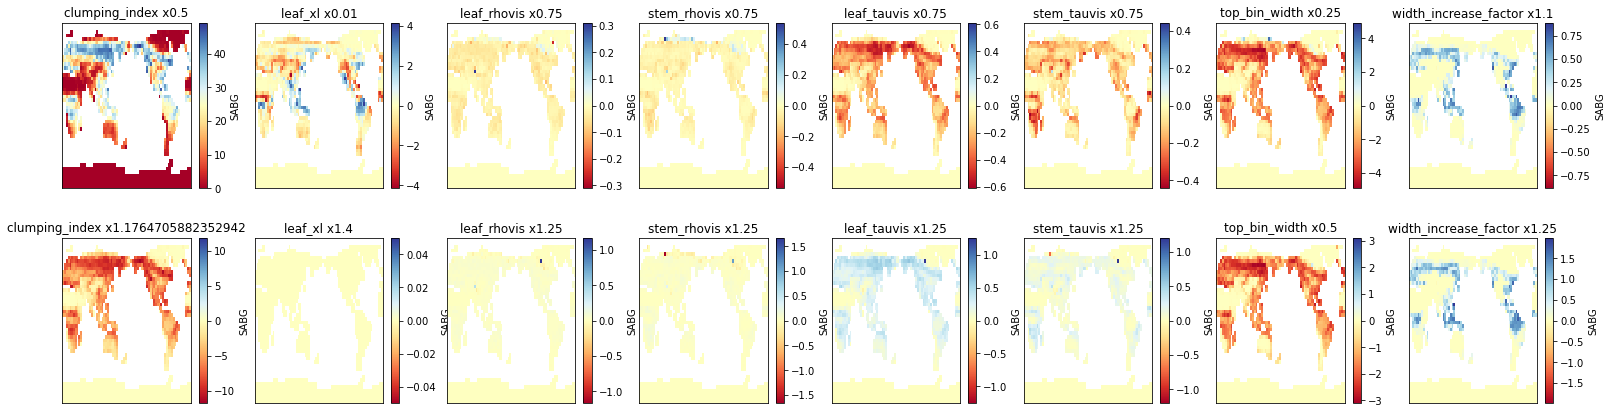

In [34]:
conv=1
make_diff_figure(dsc,3,rel,conv,ncases,pmode,parameter_list)

In [ ]:
!cat '/glade/work/rfisher/git/ctsmsep22/cime/scripts//RTM_ens1/RTM_ens1_case_12/user_nl_clm'